# Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
# Check if GPU is available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'
print("Using device:", device)


Using device: mps


In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_dim=28*28, hidden_dim=300):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            # We'll use BCEWithLogitsLoss, so no final Sigmoid() here
        )
        
    def forward(self, x):
        # Flatten the input: (N, 1, 28, 28) -> (N, 784)
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out

discriminator = Discriminator().to(device)

In [9]:
batch_size = 64
z_dim = 100   # dimension of the random noise vector
lr = 1e-3
num_epochs = 5

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, hidden_dim=300, out_dim=28*28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, out_dim),
            nn.Sigmoid()  # output in [0,1]
        )
        
    def forward(self, x):
        out = self.model(x)
        # Reshape to (N, 1, 28, 28) for images
        out = out.view(x.size(0), 1, 28, 28)
        return out

generator = Generator(z_dim=z_dim).to(device)

In [11]:
transform = transforms.ToTensor()

# Use the local MNIST data in ./data/MNIST/raw
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
val_dataset   = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Train samples: 60000
Validation samples: 10000


In [12]:
criterion = nn.BCEWithLogitsLoss()

# Separate optimizers for generator and discriminator
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [13]:
for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)
        
        # ========== Train Discriminator ==========

        # 1) Real images
        # Label = 1.0 for real
        real_labels = torch.ones(batch_size_curr, 1).to(device)
        # Pass real images through the discriminator
        d_out_real = discriminator(real_images)
        d_loss_real = criterion(d_out_real, real_labels)
        
        # 2) Fake images
        # Label = 0.0 for fake
        noise = torch.randn(batch_size_curr, z_dim, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)
        # Pass fake images through the discriminator
        d_out_fake = discriminator(fake_images.detach())  
        # Use .detach() so we don't backprop through the generator on this step
        d_loss_fake = criterion(d_out_fake, fake_labels)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        
        # Backprop and update the discriminator
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()
        
        # ========== Train Generator ==========

        # For generator, we want the fake images to be classified as real (label=1)
        # so we compute the loss with real_labels (ones).
        g_out = discriminator(fake_images)  # no detach() here
        g_loss = criterion(g_out, real_labels)
        
        # Backprop and update the generator
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"D Loss: {d_loss.item():.4f} | "
          f"G Loss: {g_loss.item():.4f}")


Epoch [1/5] | D Loss: 0.7862 | G Loss: 1.8748
Epoch [2/5] | D Loss: 0.8254 | G Loss: 1.6127
Epoch [3/5] | D Loss: 0.4871 | G Loss: 2.2669
Epoch [4/5] | D Loss: 0.6106 | G Loss: 2.4565
Epoch [5/5] | D Loss: 0.5468 | G Loss: 2.1538


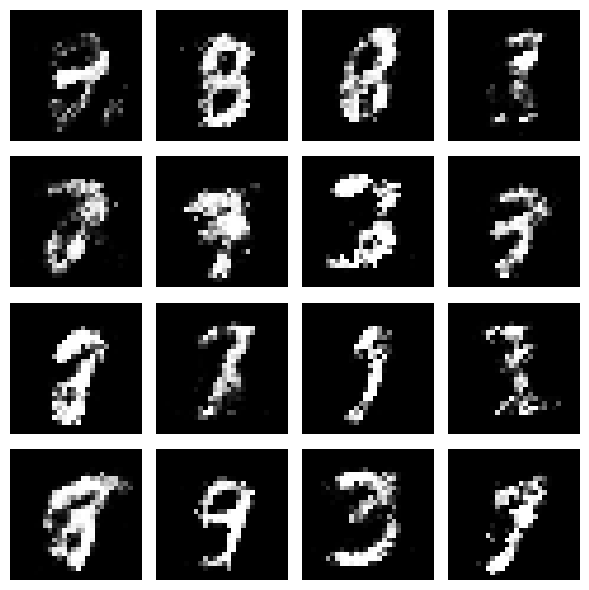

In [14]:
import numpy as np

# Generate some images
generator.eval()
with torch.no_grad():
    test_noise = torch.randn(16, z_dim, device=device)
    fake_samples = generator(test_noise)

# Move to CPU for plotting
fake_samples = fake_samples.cpu().numpy()

# Plot a 4x4 grid of generated images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(16):
    row, col = divmod(i, 4)
    axes[row, col].imshow(fake_samples[i, 0], cmap='gray', vmin=0, vmax=1)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
